In [49]:
from __future__ import unicode_literals
import os
from gensim import corpora, models
import numpy as np
import pickle
from itertools import groupby
from operator import itemgetter
import sys  

#reload(sys)  
#sys.setdefaultencoding('utf8')

In [50]:
#Lecture des données
texts = pickle.load(open(os.getcwd()+"/5000/texts.obj", "rb"))
#Liste des paths de tous les documents selon leur IDs
infopath= pickle.load(open(os.getcwd()+"/5000/infopath.obj", "rb"))
infolength= pickle.load(open(os.getcwd()+"/5000/infolength.obj", "rb"))

In [51]:
import unicodedata #remplacer les accents 
texts = [[unicodedata.normalize('NFD', word).encode('ascii', 'ignore') for word in text] for text in texts]

In [52]:
#construction du dictionnaire pour LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts] #term_frequency

In [53]:
num_topics=30 #nombre de topics
len_vocab=len(dictionary.token2id) #nombre de mots dans le vocabulaire

In [54]:
#Execution de LDA
lda = models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, workers =2,chunksize=10000, passes=1)

In [55]:
#______________Preparation des input pour la visualisation______________________

#Pour avoir tout le vocabulaire ou chaque mot est represente par son identifiant
def doc_lengths(texts):
    doc_lengths = []
    for text in texts:
        doc_lengths.append(len(text))
    return doc_lengths

# Distribution des probabilites qu'un document i (lignes) ait un topic j (colonnes)
def doc_topic_dists(corpus, lda, num_topics):
    doc_topic_dists = []
    for doc in range(len(corpus)):
        list_topic_proba = [0]*num_topics
        temp = lda.get_document_topics(corpus[doc], minimum_probability=0)
        for topic, proba in temp:
            list_topic_proba[topic]=proba
        doc_topic_dists.append(list_topic_proba)
    return doc_topic_dists

# Distribution des probabilites qu'un topic i (lignes) contienne un term j (colonnes)
def topic_term_dists(lda, num_topics, len_vocab):
    topic_term_dists = []
    for topic in range(num_topics):
        list_term_proba = [0]*len_vocab
        temp = lda.get_topic_terms(topic,  topn=len_vocab)
        for term, proba in temp:
            list_term_proba[term-1] = proba
        topic_term_dists.append(list_term_proba)
    return topic_term_dists

#Pour avoir tout le vocabulaire ou chaque mot est represente par son identifiant
def get_vocabularyIDs(dictionary_tokens):
    vocabulary = []
    for token in dictionary_tokens:
        vocabulary.append(dictionary_tokens[token])
    return vocabulary

#Pour avoir tout le vocabulaire ou chaque mot est represente dans sa forme normale
def get_vocabularyAlpha(dictionary_tokens):
    vocabulary = []
    for token in dictionary_tokens:
        vocabulary.append(dictionary_tokens[token])
    return vocabulary

#Pour avoir les fréquences de chaque mot dans le corpus dans le même ordre que le vocabulaire
def get_term_frequency(corpus):
    term_frequency= []
    flatenText = [item for sublist in corpus for item in sublist]
    first = itemgetter(0)
    sums ={}
    sums = {(k, sum(item[1] for item in tups_to_sum))
        for k, tups_to_sum in groupby(sorted(flatenText, key=first), key=first)}
    for t in sums:
        term_frequency.append(t[1])
    return term_frequency

#Combine les fonctions ci-dessus pour créer un dictionnaire
def pyLDAvisData(lda, num_topics, len_vocab, corpus, text, dictionary_tokens):
    data = {'topic_term_dists':topic_term_dists(lda,num_topics,len_vocab), 
            'doc_topic_dists': doc_topic_dists(corpus, lda, num_topics),
            'doc_lengths': doc_lengths(text),
            'vocab': get_vocabularyAlpha(dictionary_tokens),
            'term_frequency':get_term_frequency(corpus)
           }
    return data

In [56]:
data = pyLDAvisData(lda, num_topics, len(dictionary.token2id), corpus, texts, dictionary.id2token)

# PyLDAvis

In [48]:
import pyLDAvis
# Utiliser nos donner pour créer une visualisation LDAvis
lda_model_data = data
lda_vis_data = pyLDAvis.prepare(**lda_model_data)
pyLDAvis.display(movies_vis_data)

# Tendence des topics

### I  - For each topic get the most dominant topic i.e. one topic per document
### II - For each topic get the all topics according to treshold

In [57]:
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline 

In [58]:
paths = "/media/nawel/E4DC5C32DC5C016A/AIC/REI/Projet/REI_SE_TM/Code/Subset5000/" 
# à replacer celon ou se trouve le corpus, le but est d'extraire les année e les mois à partir des noms des documents
# donc si les documents sont dans "Bureau/Corpus/2015/10/01/file.tx alors paths = 'Bureau/Corpus/'

In [59]:
#A parir de la martice doc_topic_dists, on réccupére la liste des documents (IDs) dans lesquels un topic appartient 
#On utilise ensuit les IDs des documents pour réccupérer leurs paths de la liste "infopath"
#Obtenir le Path nous permet de réccupéré la partie qui indique l'année et le mois de l'apparition de l'article

# 1- En premier lieu on considère que chaque document contient un seul topic, donc pour chaque document on réccupére le topic 
# ayant la plus grande probabilité 
# Le dictionnaire retournée ici a pour clé l'id du topic e pour valeur une liste des annees dans lequel il apparait
def get_topic_apperences_year_month(data, info):
    dict_topics = {}
    for i in range(0,len(data)):
        idt = data[i].index(max(data[i]))
        dict_topics.setdefault(idt, []).append(info[i].replace(paths, '')[:7])
    return dict_topics
# Le dictionnaire retournée ici a pour clé l'id du topic e pour valeur une liste des annees/mois dans lequel il apparait

def get_topic_apperences_year(data, info):
    dict_topics = {}
    for i in range(0,len(data)):
        idt = data[i].index(max(data[i]))
        dict_topics.setdefault(idt, []).append(info[i].replace(paths, '')[:4])
    return dict_topics

# 2- En second lieu on considère que chaque document contient plusieurs topic, donc pour chaque document on réccupére la liste des
# topics ayant une probabilité > seuil

def get_topic_apperences_year_month_threshold(data, info,threshold):
    dict_topics = {}
    for i in range(0,len(data)):
        idt = find_indices(data[i], lambda e: e > 0.1)
        for j in idt:
            dict_topics.setdefault(j, []).append(info[i].replace(paths, '')[:7])
    return dict_topics

def get_topic_apperences_year_threshold(data, info, threshold):
    dict_topics = {}
    for i in range(0,len(data)):
        idt = find_indices(data[i], lambda e: e > 0.1)
        for j in idt:
            dict_topics.setdefault(j, []).append(info[i].replace(paths, '')[:4])
    return dict_topics

def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

In [60]:
# Pour déssiner le plot, on utilise un compteur qui compte pour chaque topic (clé du dictionnaire) le nombre de fréquence de chaque 
# années

def plot_topic_tendences(topic, data, info, typePlot='bar', period='year', threshold = 0):
    prop_iter = iter(plt.rcParams['axes.prop_cycle'])
    topic_doc_apperence = {}
    if (threshold > 0):
        if (period =='year'):
            topic_doc_apperence = get_topic_apperences_year_threshold(data, info, threshold)
        else:
            topic_doc_apperence = get_topic_apperences_year_month_threshold(data, info, threshold)
    else:
        if (period =='year'):
            topic_doc_apperence = get_topic_apperences_year(data, info)
        else:
            topic_doc_apperence = get_topic_apperences_year_month(data, info)
     
    cnt = Counter(topic_doc_apperence[topic])
    cnt = sorted(cnt.items(),key=itemgetter(0))
    dates = []
    frequencies = []
    for c in cnt:
        dates.append(str(c[0]))
        frequencies.append(c[1])
    dates
    x = [i for i in range(len(dates))]
    plt.xticks(x, dates)
    if (typePlot == 'bar'):
        plt.bar(x,frequencies,color=next(prop_iter)['color'])
    else:
        plt.plot(x, frequencies, marker='x')
      
    plt.setp(plt.xticks()[1], rotation=90)
    plt.title('Topic ' + str(topic+1) + ' tendance over the corpus')
    plt.xlabel('Dates')
    plt.ylabel('# Aapperences')
    plt.legend() 
    plt.show()
    

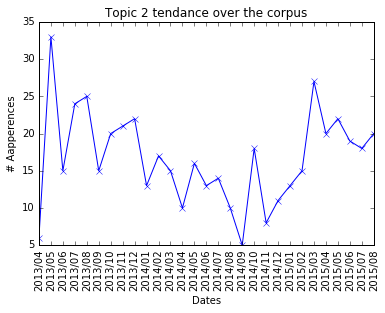

In [61]:
id_topic = 1 #topic à visualiser
plot_topic_tendences(id_topic, data['doc_topic_dists'], infopath, typePlot='line', period='month', threshold=0)

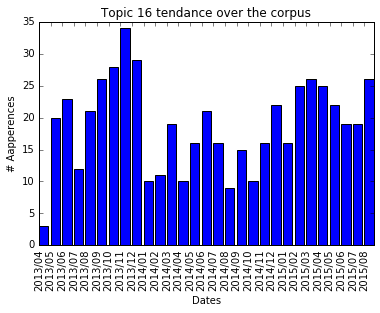

In [62]:
id_topic = 15 #topic à visualiser
plot_topic_tendences(id_topic, data['doc_topic_dists'], infopath, typePlot='bar', period='month', threshold=0)

# Cloud tags

In [63]:
from wordcloud import WordCloud
from PIL import Image

In [69]:
# Pour afficher le word cloud, on réccupére d'abbord le top N des mot représentant un topic et au lieux d'uriliser les féquences, 
# on utilise les probabilité associé à chque terme
def topics_to_counter(topic, nbrwords):
    word_prob =(lda.print_topic(topic, topn=nbrwords)).split("+")
    cnt = Counter()
    for w in word_prob:
        cnt[w.rsplit('*', 1)[1]] = float(w.rsplit('*', 1)[0])
    return cnt

def cloudTag(cnt, mask):
    #le masque est utilisé pour affiché un wordcloud plutot créative
    mask = np.array(Image.open(mask))

    wordcloud = WordCloud(background_color="white", width=800, height=600,  mask=mask, relative_scaling=.8)\
                .generate_from_frequencies(cnt.items())
    wordcloud.to_file("wordcloud.png")

    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


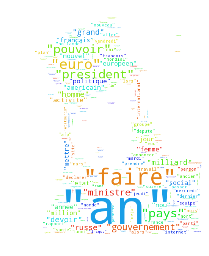

In [70]:
cnt = topics_to_counter(1, 300)
cloudTag(cnt, 'mask2.jpg')

# Topic shares

In [76]:
import random
import colorsys

# Pour afficher les topics share sous forme de stacked bar on passe fix le nombre de documents à comparer, 
# Pour chaque document on réccupere la distribition "doc_topic_dists" associée

def get_new_doc_topic_dists(data, info, topics, documents):
    indexes = [random.randrange(len(data)) for i in range(documents)]
    doctopic = np.array([])
    docnames = []
    for i in range(0,len(indexes)):
        if (i==0):
            doctopic =  np.hstack((doctopic, np.array(data[indexes[i]])))
            docnames.append(info[indexes[i]].replace(paths, '')[11:])
        else:
            doctopic =  np.vstack((doctopic, np.array(data[indexes[i]])))
            docnames.append(info[indexes[i]].replace(paths, '')[11:])
    return doctopic, docnames

# Utiliser la distribution et la liste des document pour ploter les topics share de chaque document
def topics_share_stackedBar(doctopic, docnames):
    D, T = np.array(doctopic).shape # D documents, T topics
    colors_hsv = [(x*1.0/T, 0.5, 0.5) for x in range(T)]
    colors_rgb = map(lambda x: colorsys.hsv_to_rgb(*x), colors_hsv)
   
    ind = np.arange(D) 
    width = 0.5 
    plots = []
    cumule_bar = np.zeros(D)
        
    for t in range(T):
       
        if t == 0:
            p = plt.bar(ind, doctopic[:, t], width, color=colors_rgb[t])
        else:
            p = plt.bar(ind, doctopic[:, t], width, bottom=cumule_bar, color=colors_rgb[t])
        cumule_bar += doctopic[:, t]
        plots.append(p)

    plt.ylim((0, 1))
    plt.ylabel('Topics')
    plt.title('Topics in novels')
    plt.xticks(ind+width/2, docnames)
    plt.setp(plt.xticks()[1], rotation=90)
    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(t) for t in range(T)]
    plt.legend([p[0] for p in plots], topic_labels)
    
    plt.show()
    
def topics_share_heatmap(doctopic, docnames):
    D, T  = np.array(doctopic).shape
    plt.pcolor(doctopic, norm=None, cmap='Blues')
    plt.yticks(np.arange(doctopic.shape[0])+0.5, docnames);
    topic_labels = ['Topic #{}'.format(t) for t in range(T)]
    plt.xticks(np.arange(doctopic.shape[1])+0.5, topic_labels);
    plt.gca().invert_yaxis()
    plt.xticks(rotation=90)
    plt.colorbar(cmap='Blues')
    plt.tight_layout() 
    plt.figure(figsize=(500,100))
    plt.show()

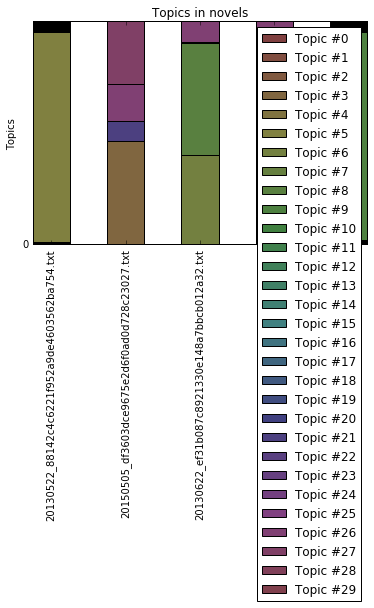

In [77]:
doctopic, docnames = get_topics_documents_matrice(data['doc_topic_dists'], infopath, num_topics, 5)
topics_share_stackedBar(doctopic, docnames)


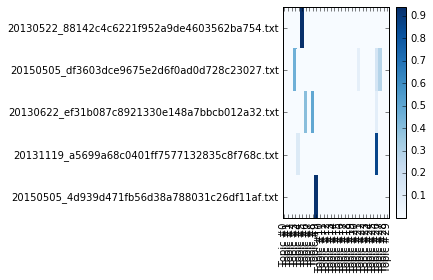

In [78]:
topics_share_heatmap(doctopic, docnames)